In [1]:
# 1️⃣ Install and import dependencies
!pip install torch torchvision matplotlib -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# 2️⃣ Download and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize pixel values
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.68MB/s]


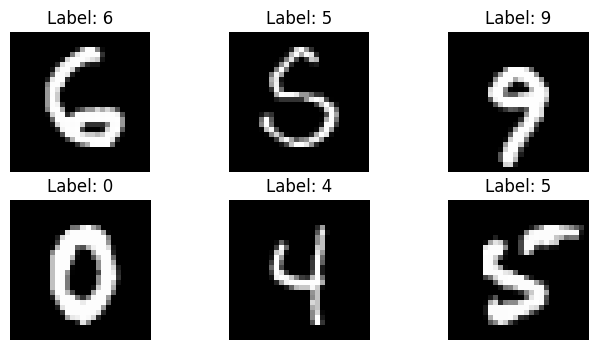

In [3]:
# 3️⃣ Visualize sample images
images, labels = next(iter(trainloader))

plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [4]:
# 4️⃣ Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)   # input: 1x28x28 → output: 32x26x26
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # input: 32x26x26 → output: 64x24x24

        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)  # 64*12*12 = 9216
        self.fc2 = nn.Linear(128, 10)    # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# 5️⃣ Set up training components
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [6]:
# 6️⃣ Train CNN
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Training loss: {running_loss/len(trainloader):.4f}")

Epoch 1 - Training loss: 0.2348
Epoch 2 - Training loss: 0.0948
Epoch 3 - Training loss: 0.0715


In [7]:
# 7️⃣ Evaluate CNN
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.78%


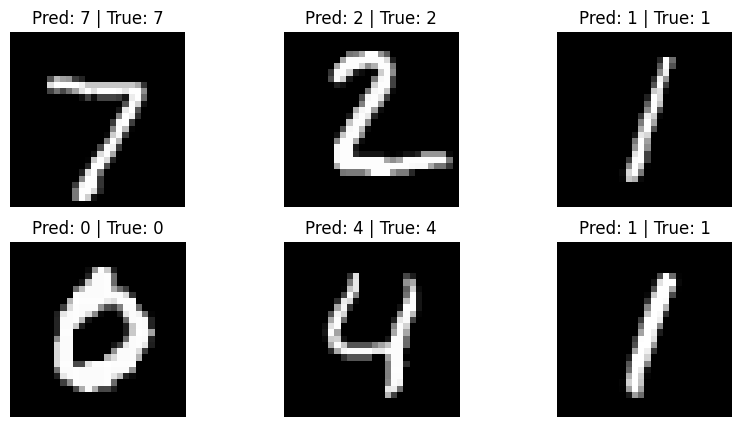

In [8]:
# 8️⃣ Sanity check: visualize predictions
images, labels = next(iter(testloader))
output = model(images)
_, preds = torch.max(output, 1)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [9]:
# 9️⃣ Save trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')

In [10]:
!ls

data  mnist_cnn.pth  sample_data
